In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
# Load the Excel file
excel_file = "nbac_summarystats_1972_2023_20240530.xlsx"

df = pd.read_excel(excel_file, sheet_name='nbac_1972_2023_20240530')

# drop the first 3 rows and make the 4th row header
df.columns = df.iloc[3]
df = df.drop(index=[0, 1, 2, 3])
df = df.reset_index(drop=True)

# Convert columns to appropriate types
df['YEAR'] = df['YEAR'].astype(int)
df['ADJ_HA'] = df['ADJ_HA'].astype(float)

# make a column for before and after 2006
df['before_after_2006'] = df['YEAR'].apply(lambda x: 'before' if x <= 2006 else 'after')

# get percetage null for each column
def get_percentage_null(df):
    return df.isnull().sum() / len(df) * 100
percentage_null = get_percentage_null(df)
print(percentage_null)

3
YEAR                  0.000000
NFIREID               0.000000
BASRC                 0.000000
FIREMAPS              0.000000
FIREMAPM              0.000000
FIRECAUS              0.000000
HS_SDATE             72.226650
HS_EDATE             72.226650
AG_SDATE             23.439384
AG_EDATE             67.686303
CAPDATE              61.382537
POLY_HA               0.000000
ADJ_HA                0.000000
ADJ_FLAG             42.763440
ADMIN_AREA            0.000000
NATPARK              95.553648
PRESCRIBED           99.327735
VERSION               0.000000
GID                   0.000000
before_after_2006     0.000000
dtype: float64


3,YEAR,NFIREID,BASRC,FIREMAPS,FIREMAPM,FIRECAUS,HS_SDATE,HS_EDATE,AG_SDATE,AG_EDATE,CAPDATE,POLY_HA,ADJ_HA,ADJ_FLAG,ADMIN_AREA,NATPARK,PRESCRIBED,VERSION,GID,before_after_2006
0,2022,439,MAFiMS,Sentinel-2,Processed imagery,Natural,2022-06-28 00:00:00,2022-10-02 00:00:00,2022-06-26 00:00:00,NaN,2022-09-16 00:00:00,45023.957801,45023.957801,NaN,AB,NaN,NaN,20240530,2022_439,after
1,2022,74,MAFiMS,Sentinel-2,Processed imagery,Natural,2022-07-07 00:00:00,2022-07-08 00:00:00,2022-07-08 00:00:00,2022-07-18 00:00:00,2022-09-08 00:00:00,737.755249,737.755249,NaN,NT,NaN,NaN,20240530,2022_74,after
2,2022,149,MAFiMS,Landsat,Processed imagery,Natural,2022-07-08 00:00:00,2022-08-26 00:00:00,2022-06-21 00:00:00,2022-11-03 00:00:00,2022-10-22 00:00:00,9572.430492,9572.430492,NaN,NT,NaN,NaN,20240530,2022_149,after
3,2022,156,MAFiMS,Sentinel-2,Processed imagery,Natural,2022-08-17 00:00:00,2022-10-03 00:00:00,2022-08-18 00:00:00,2022-10-27 00:00:00,2022-10-17 00:00:00,26761.761894,26761.761894,NaN,NT,NaN,NaN,20240530,2022_156,after
4,2022,281,MAFiMS,Sentinel-2,Processed imagery,Undetermined,2022-07-04 00:00:00,2022-07-07 00:00:00,NaN,NaN,2022-08-23 00:00:00,400.728797,400.728797,NaN,YT,NaN,NaN,20240530,2022_281,after


In [ ]:
# change the HS_EDATE AG_SDATE AG_EDATE CAPDATE columns to datetime
df['HS_EDATE'] = pd.to_datetime(df['HS_EDATE'], errors='coerce')
df['HS_SDATE'] = pd.to_datetime(df['HS_SDATE'], errors='coerce')
df['AG_SDATE'] = pd.to_datetime(df['AG_SDATE'], errors='coerce')
df['AG_EDATE'] = pd.to_datetime(df['AG_EDATE'], errors='coerce')
df['CAPDATE'] = pd.to_datetime(df['CAPDATE'], errors='coerce')

# make a new col for the middle of the AG_SDATE nd the AG_EDATE
df['HS_MID'] = (
    (df['HS_SDATE'].astype('int64') + df['HS_EDATE'].astype('int64')) // 2
).astype('datetime64[ns]')

# change the AG_MID column to datetime
df['AG_MID'] = pd.to_datetime(df['AG_MID'], errors='coerce')

# make a new column for the month
df['month'] = df['AG_SDATE'].dt.month

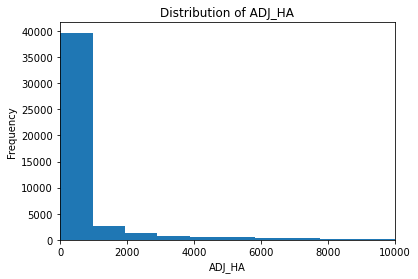

In [50]:
# see the distribtuion of ADJ_HA for the observations with null AG_SDATE
# get the distribution of ADJ_HA
plt.hist(df['ADJ_HA'].dropna(), bins=1000)
plt.xlabel('ADJ_HA')
plt.ylabel('Frequency')
plt.title('Distribution of ADJ_HA')
plt.xlim(0, 10000)
plt.show()


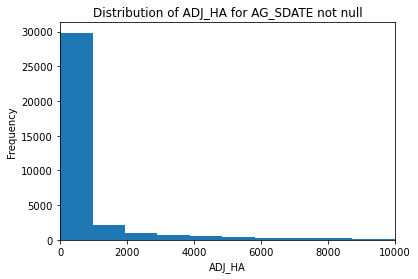

In [49]:
# see the disributrion of the ADJ_HA for the observations with not null AG_SDATE
plt.hist(df['ADJ_HA'][df['AG_SDATE'].notnull()], bins=1000)
plt.xlabel('ADJ_HA')
plt.ylabel('Frequency')
plt.title('Distribution of ADJ_HA for AG_SDATE not null')
# set x axis limit
plt.xlim(0, 10000)
plt.show()

## Sunspots Data

In [39]:
# sunspots data 

# import observed-solar-cycle-indices.json file 
import json

with open('observed-solar-cycle-indices.json') as f:
    sunspots = json.load(f)

# convert to dataframe
sunspots_df = pd.DataFrame(sunspots)

sunspots_df

,time-tag,ssn,smoothed_ssn,observed_swpc_ssn,smoothed_swpc_ssn,f10.7,smoothed_f10.7
0,1749-01,96.7,-1.0,-1.00,-1.0,-1.00,-1.0
1,1749-02,104.3,-1.0,-1.00,-1.0,-1.00,-1.0
2,1749-03,116.7,-1.0,-1.00,-1.0,-1.00,-1.0
3,1749-04,92.8,-1.0,-1.00,-1.0,-1.00,-1.0
4,1749-05,141.7,-1.0,-1.00,-1.0,-1.00,-1.0
...,...,...,...,...,...,...,...
3311,2024-12,154.6,-1.0,134.90,-1.0,196.90,-1.0
3312,2025-01,137.0,-1.0,145.23,-1.0,189.39,-1.0
3313,2025-02,154.6,-1.0,152.64,-1.0,184.31,-1.0
3314,2025-03,134.2,-1.0,127.74,-1.0,163.78,-1.0


In [ ]:
# select only the fires with a date
df_no_na = df[df['AG_SDATE'].notnull()]

# group by year and the month
df_grouped_nona = df_no_na.groupby(['YEAR', 'month']).agg({'ADJ_HA': 'sum'}).reset_index()

# for the missing months in the years add the rows and fill with 0
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
years = df_grouped_nona['YEAR'].unique()
# create a new dataframe with all the months and years
df_all_months = pd.DataFrame(
    [(year, month) for year in years for month in months],
    columns=['YEAR', 'month']
)
# merge the two dataframes
df_grouped_nona = pd.merge(
    df_all_months,
    df_grouped_nona,
    on=['YEAR', 'month'],
    how='left'
)
# fill the missing values with 0
df_grouped_nona['ADJ_HA'] = df_grouped_nona['ADJ_HA'].fillna(0)
# make a new column for the month
df_grouped_nona['month'] = df_grouped_nona['month'].astype(int)
# make a new column for the year
df_grouped_nona['YEAR'] = df_grouped_nona['YEAR'].astype(int)

,YEAR,month,ADJ_HA
0,1972,1,0.000000
1,1972,2,0.000000
2,1972,3,56.418211
3,1972,4,194.113486
4,1972,5,77390.522517
...,...,...,...
619,2023,8,757163.129927
620,2023,9,53266.698045
621,2023,10,193.084998
622,2023,11,63.953306


In [ ]:
# change time-tag to datetime from sunpots df
sunspots_df['time-tag'] = pd.to_datetime(sunspots_df['time-tag'], format='%Y-%m')

# subset the sunspots df to the years in the df_grouped_nona
sunspots_df = sunspots_df[sunspots_df['time-tag'].dt.year.isin(df_grouped_nona['YEAR'].unique())]

# make a new column for the month
x_exog = sunspots_df['ssn']

# time series of the burned area
y = df_grouped_nona['ADJ_HA']

In [88]:
# Ensure YEAR and month are combined into a datetime index
df_grouped_nona['date'] = pd.to_datetime(df_grouped_nona[['YEAR', 'month']].assign(day=1))
df_grouped_nona.set_index('date', inplace=True)

# Update y to use the datetime index
y = df_grouped_nona['ADJ_HA']

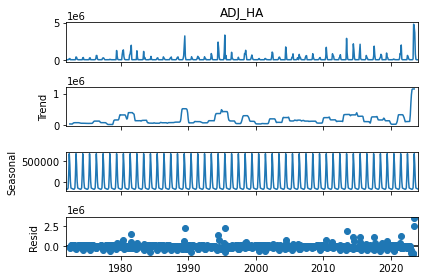

In [89]:
decomposition = seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [ ]:
# Define the search space.
p = range(1, 6)
d = range(0, 2)
q = range(0, 2)

# Create an interative list of ps, ds, qs.
from itertools import product
pdq = list(product(p, d, q))

# Seasonal parameters. One year back.
ps = range(0, 4)
ds = range(0, 1)
qs = range(0, 1)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(product(ps, ds, qs))]

y = df_grouped_nona['ADJ_HA']

aic_out = []

for param in pdq:
  for param_seasonal in seasonal_pdq:
      mod = SARIMAX(y,
                    exog=np.asarray(x_exog),
                    order=param,
                    seasonal_order=param_seasonal,
                    enforce_stationarity=True,
                    enforce_invertibility=False
                    )
      results = mod.fit(verbose=False)
      aic_out.append([param, param_seasonal, results.aic])
      print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

# Nicer formatting
aic_out = pd.DataFrame(aic_out,
                       columns = ['(p,q,r)', '(ps, qs, rs, S)', 'AIC'])

In [78]:
# Nicer formatting
aic_out = pd.DataFrame(aic_out,
                       columns = ['(p,q,r)', '(ps, qs, rs, S)', 'AIC'])

aic_out.sort_values(by='AIC', ascending=True)

,"(p,q,r)","(ps, qs, rs, S)",AIC
22,"(2, 0, 1)","(2, 0, 0, 12)",17817.587847
34,"(3, 0, 0)","(2, 0, 0, 12)",17817.872587
18,"(2, 0, 0)","(2, 0, 0, 12)",17817.975618
23,"(2, 0, 1)","(3, 0, 0, 12)",17818.280675
35,"(3, 0, 0)","(3, 0, 0, 12)",17818.367101
...,...,...,...
72,"(5, 1, 0)","(0, 0, 0, 12)",17978.632282
56,"(4, 1, 0)","(0, 0, 0, 12)",17987.196279
40,"(3, 1, 0)","(0, 0, 0, 12)",18001.313472
24,"(2, 1, 0)","(0, 0, 0, 12)",18028.440231


In [79]:
# Fit the SARIMAX model
mod = SARIMAX(y, exog=np.asarray(x_exog), order=(2, 0, 1), seasonal_order=(2, 0, 0, 12))
results = mod.fit()

# Print the summary
print(results.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.42823D+01    |proj g|=  8.63759D-02

At iterate    5    f=  1.42658D+01    |proj g|=  5.09485D-04

At iterate   10    f=  1.42657D+01    |proj g|=  3.58214D-03

At iterate   15    f=  1.42657D+01    |proj g|=  3.90232D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     15     18      1     0     0   3.902D-05   1.427D+01
  F =   14.265695389130519     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
        

## 2023 

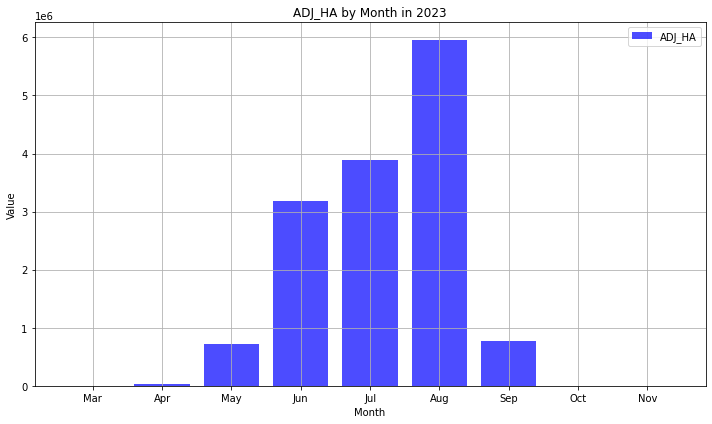

In [33]:
df_2023 = df[df['YEAR'] == 2023]

# drop the rows with null values in HS_SDATE or HS_EDATE
df_2023 = df_2023.dropna(subset=['HS_SDATE', 'HS_EDATE'])

# group by the month 
df_2023_grouped = df_2023.groupby('month').agg(
    {'ADJ_HA': 'sum', 'HS_MID': 'count'}
).reset_index()

df_2023_grouped

# plot the data
plt.figure(figsize=(10, 6))
plt.bar(df_2023_grouped['month'], df_2023_grouped['ADJ_HA'], color='blue', alpha=0.7, label='ADJ_HA')
plt.title('ADJ_HA by Month in 2023')
plt.xlabel('Month')
plt.ylabel('Value')
plt.xticks(df_2023_grouped['month'], ['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov'])
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## 1997

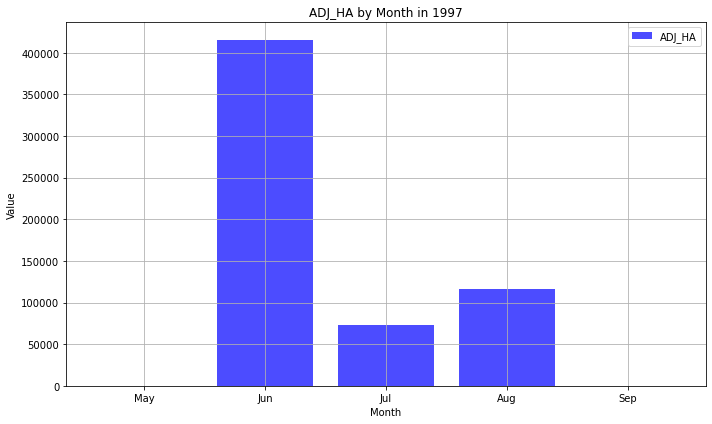

In [37]:
df_2023 = df[df['YEAR'] == 1997]

# drop the rows with null values in HS_SDATE or HS_EDATE
df_2023 = df_2023.dropna(subset=['HS_SDATE', 'HS_EDATE'])

# group by the month 
df_2023_grouped = df_2023.groupby('month').agg(
    {'ADJ_HA': 'sum', 'HS_MID': 'count'}
).reset_index()

df_2023_grouped

# plot the data
plt.figure(figsize=(10, 6))
plt.bar(df_2023_grouped['month'], df_2023_grouped['ADJ_HA'], color='blue', alpha=0.7, label='ADJ_HA')
plt.title('ADJ_HA by Month in 1997')
plt.xlabel('Month')
plt.ylabel('Value')
plt.xticks(df_2023_grouped['month'], ['May', 'Jun', 'Jul', 'Aug', 'Sep'])
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## 1989

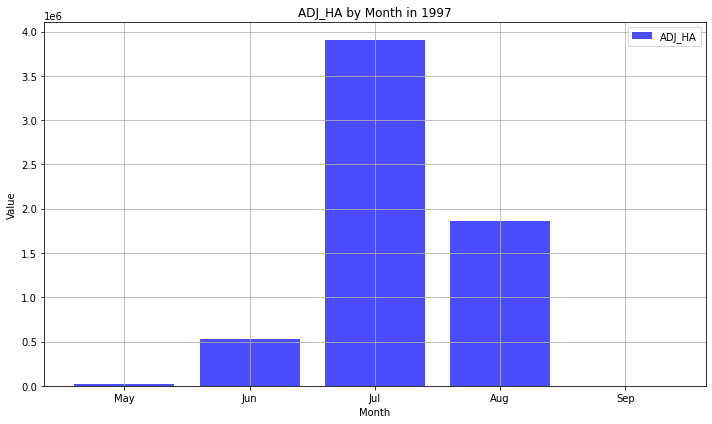

In [36]:
df_2023 = df[df['YEAR'] == 1989]

# drop the rows with null values in HS_SDATE or HS_EDATE
df_2023 = df_2023.dropna(subset=['HS_SDATE', 'HS_EDATE'])

# group by the month 
df_2023_grouped = df_2023.groupby('month').agg(
    {'ADJ_HA': 'sum', 'HS_MID': 'count'}
).reset_index()

df_2023_grouped

# plot the data
plt.figure(figsize=(10, 6))
plt.bar(df_2023_grouped['month'], df_2023_grouped['ADJ_HA'], color='blue', alpha=0.7, label='ADJ_HA')
plt.title('ADJ_HA by Month in 1997')
plt.xlabel('Month')
plt.ylabel('Value')
plt.xticks(df_2023_grouped['month'], ['May', 'Jun', 'Jul', 'Aug', 'Sep'])
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:

# get data from before 2006
df_before = df[df['before_after_2006'] == 'before']

# percentage of fires less than 100 ha burned
np.mean(df_before['POLY_HA'] < 100)



0.5284302608132189

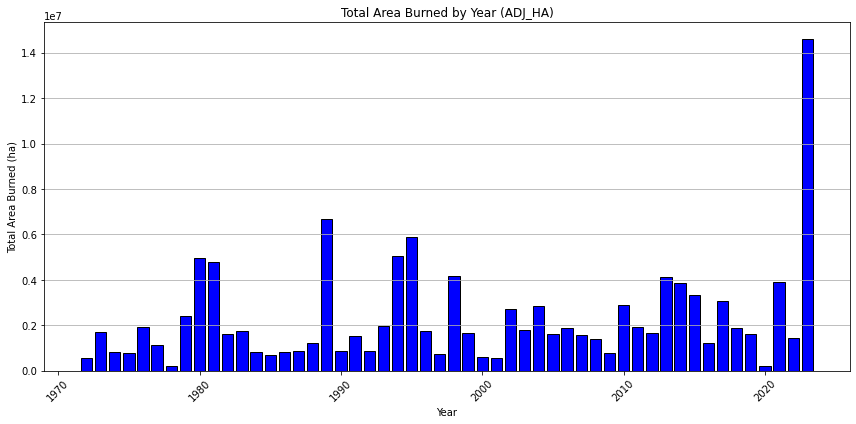

In [ ]:
# make bar graph of total ADJ_HA by year
df_grouped = df.groupby('YEAR')['ADJ_HA'].sum().reset_index()
plt.figure(figsize=(12, 6))
plt.bar(df_grouped['YEAR'], df_grouped['ADJ_HA'], color='blue', edgecolor='black')
plt.title("Total Area Burned by Year (ADJ_HA)")
plt.xlabel("Year")
plt.ylabel("Total Area Burned (ha)")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


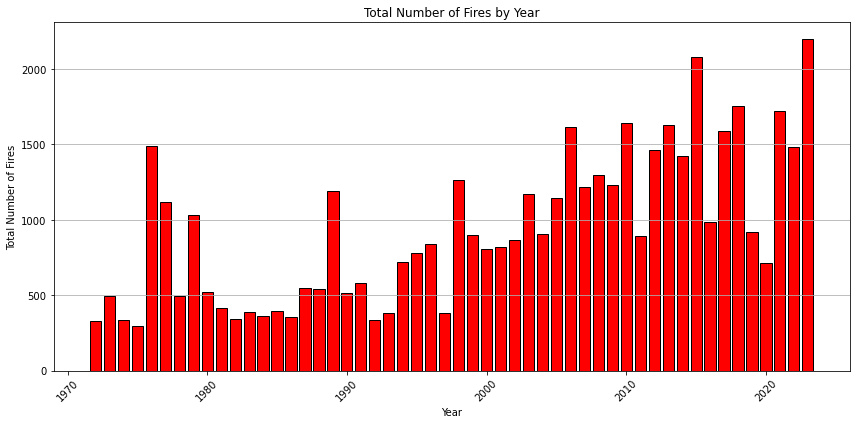

In [9]:
# total number of fires by year
df_grouped = df.groupby('YEAR')['NFIREID'].count().reset_index()
plt.figure(figsize=(12, 6))
plt.bar(df_grouped['YEAR'], df_grouped['NFIREID'], color='red', edgecolor='black')
plt.title("Total Number of Fires by Year")
plt.xlabel("Year")
plt.ylabel("Total Number of Fires")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

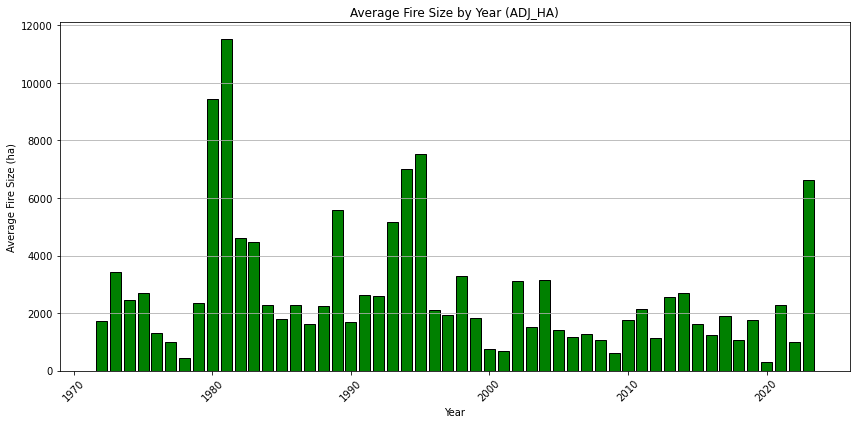

In [10]:
# make a plot average fire size by year
df_grouped = df.groupby('YEAR')['ADJ_HA'].mean().reset_index()
plt.figure(figsize=(12, 6))
plt.bar(df_grouped['YEAR'], df_grouped['ADJ_HA'], color='green', edgecolor='black')
plt.title("Average Fire Size by Year (ADJ_HA)")
plt.xlabel("Year")
plt.ylabel("Average Fire Size (ha)")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

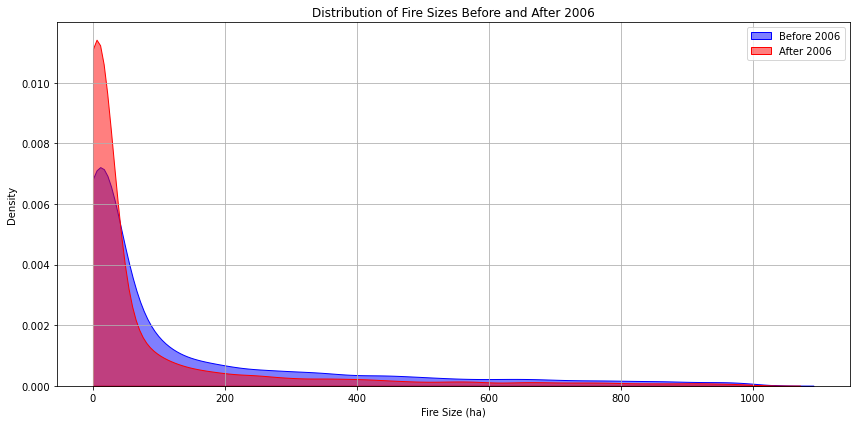

In [38]:
# make a distribution of the fire sizes make two distributions for up to 2006 and after 2007
# make kde overlay
# cut off for only values less than 200000
# restrict distribution to positive
import seaborn as sns
df_before_2007 = df[df['YEAR'] <= 2006]
df_after_2007 = df[df['YEAR'] > 2006]
df_before_2007 = df_before_2007[df_before_2007['ADJ_HA'] < 1000]
df_after_2007 = df_after_2007[df_after_2007['ADJ_HA'] < 1000]
plt.figure(figsize=(12, 6))
sns.kdeplot(df_before_2007['ADJ_HA'], color='blue', label='Before 2006', fill=True, alpha=0.5, clip=(0, None))
sns.kdeplot(df_after_2007['ADJ_HA'], color='red', label='After 2006', fill=True, alpha=0.5, clip=(0, None))
plt.title("Distribution of Fire Sizes Before and After 2006")
plt.xlabel("Fire Size (ha)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



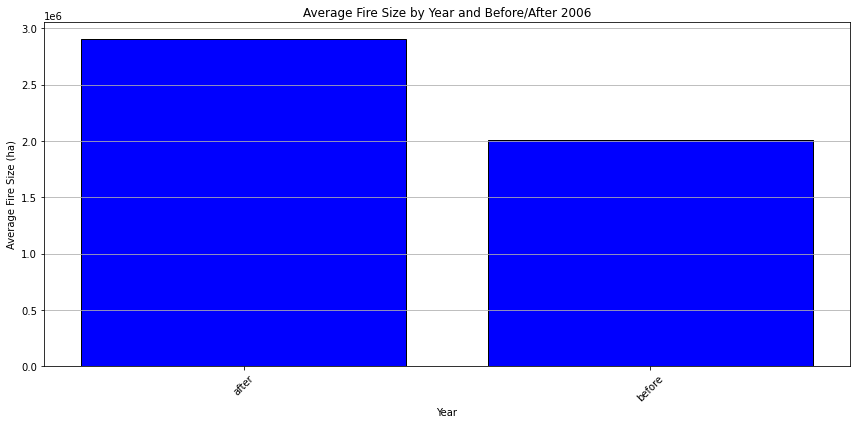

In [96]:
# group by year and before_after 2006 and sum the ADJ_HA
df_grouped = df.groupby(['YEAR', 'before_after_2006'])['ADJ_HA'].sum().reset_index()

# get the average fire size by year and before_after_2006
df_grouped_avg = df_grouped.groupby(['before_after_2006'])['ADJ_HA'].mean().reset_index()

# make a bar graph of the average fire size by year and before_after_2006
plt.figure(figsize=(12, 6))
plt.bar(df_grouped_avg['before_after_2006'], df_grouped_avg['ADJ_HA'], color='blue', edgecolor='black')
plt.title("Average Fire Size by Year and Before/After 2006")
plt.xlabel("Year")
plt.ylabel("Average Fire Size (ha)")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


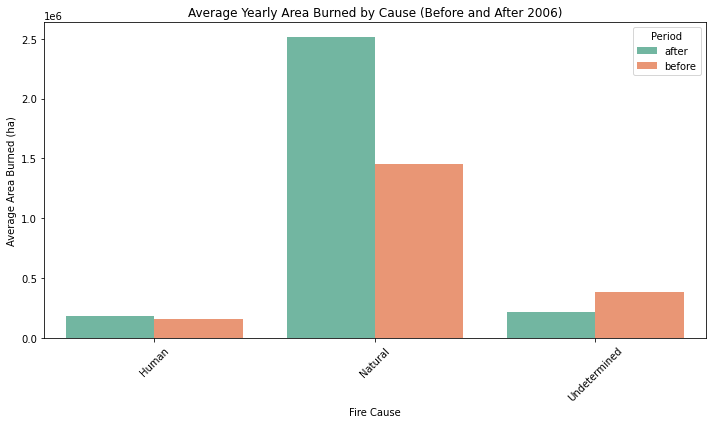

In [103]:
# group by year and before_after 2006 and sum the ADJ_HA
df_grouped_cause = df.groupby(['YEAR', 'before_after_2006', 'FIRECAUS'])['ADJ_HA'].sum().reset_index()

df_bar = df_grouped_cause.groupby(['before_after_2006', 'FIRECAUS'])['ADJ_HA'].mean().reset_index()

# visualize in a side by side bar plot
# Create a side-by-side bar plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_bar,
    x='FIRECAUS',
    y='ADJ_HA',
    hue='before_after_2006',
    palette='Set2'
)

# Add titles and labels
plt.title("Average Yearly Area Burned by Cause (Before and After 2006)")
plt.xlabel("Fire Cause")
plt.ylabel("Average Area Burned (ha)")
plt.xticks(rotation=45)
plt.legend(title="Period")
plt.tight_layout()

# Show the plot
plt.show()


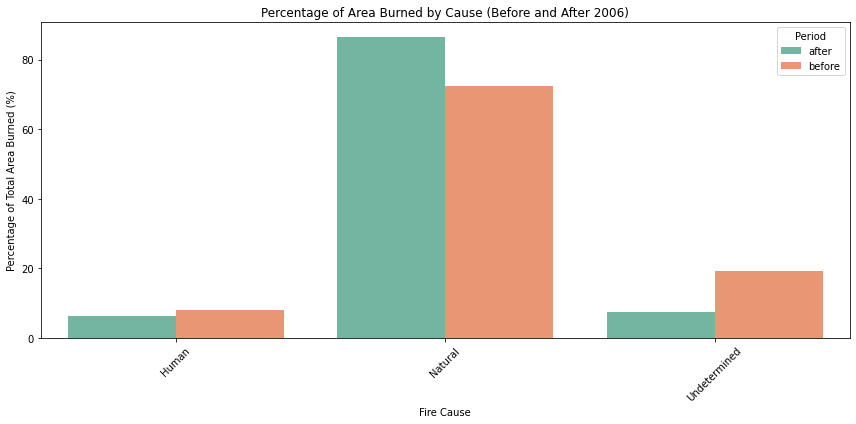

In [40]:
total_by_period = df_grouped.groupby('before_after_2006')['ADJ_HA'].transform('sum')

# Add a new column for percentages
df_grouped['PERCENTAGE'] = (df_grouped['ADJ_HA'] / total_by_period) * 100

# Create a side-by-side barplot with percentages
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_grouped,
    x='FIRECAUS',
    y='PERCENTAGE',
    hue='before_after_2006',
    palette='Set2'
)

# Add titles and labels
plt.title("Percentage of Area Burned by Cause (Before and After 2006)")
plt.xlabel("Fire Cause")
plt.ylabel("Percentage of Total Area Burned (%)")
plt.xticks(rotation=45)
plt.legend(title="Period")
plt.tight_layout()

# Show the plot
plt.show()